In [0]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import warnings
import torch
warnings.simplefilter('ignore')
%matplotlib inline

In [0]:
!pip install skorch
!pip install mlxtend

     |████████████████████████████████| 112kB 8.8MB/s 


# Load data and split data

In [0]:
data = pd.read_csv("merged_order_dummy.csv")

In [0]:
data.head()

order_in_section  speed  precipitation  ...  hour_21  hour_22  hour_23
0                 1    7.0            0.0  ...        0        0        0
1                 1    7.0            0.0  ...        0        0        0
2                 1    7.0            0.0  ...        0        0        0
3                 1    6.0            0.0  ...        0        0        0
4                 1    5.0            0.0  ...        0        0        0

[5 rows x 128 columns]

In [0]:
X = data.drop(columns=["order_in_section"])
y = data[['order_in_section']].values.reshape(-1, 1)
X.shape, y.shape

((17555, 127), (17555, 1))

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=10)

# Standardize

In [0]:
def standardize(col_name):
    scaler_precipitation = StandardScaler().fit(X_train[col_name].values.reshape(-1, 1))
    X[col_name] = scaler_precipitation.transform(X[col_name].values.reshape(-1, 1))
    X_train[col_name] = scaler_precipitation.transform(X_train[col_name].values.reshape(-1, 1))
    X_test[col_name] = scaler_precipitation.transform(X_test[col_name].values.reshape(-1, 1))
    X_val[col_name] = scaler_precipitation.transform(X_val[col_name].values.reshape(-1, 1))

In [0]:
standardize("precipitation")
standardize("speed")
standardize("tempurature")

In [0]:
scaler_y = StandardScaler().fit(y_train)
y = scaler_y.transform(y)
y_train = scaler_y.transform(y_train)
y_test = scaler_y.transform(y_test)
y_val = scaler_y.transform(y_val)

# Train NN models and Cross Validation (done manually)

In [0]:
def fit(model, X, y, loss_fn, optimizer, epochs = 1000, plotLosses=True):
    losses = []
    for i in range(epochs):
        # forward pass
        output    = model(X)

        # compute loss
        loss      = loss_fn(output, y)
        losses.append(loss)

        # Zero gradient, backward pass, gradient descent step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if(plotLosses):
        plt.plot(losses, label='train')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend();    
    return losses

In [0]:
Xtorch  = torch.FloatTensor(X_train.values).cuda()
Ytorch  = torch.FloatTensor(y_train).cuda()
Xtorch_test = torch.FloatTensor(X_test.values).cuda()
Ytorch_test = torch.FloatTensor(y_test).cuda()
Xtorch_val = torch.FloatTensor(X_val.values).cuda()
Ytorch_val = torch.FloatTensor(y_val).cuda()

In [0]:
from torch import nn

import torch.nn.functional as F

class NN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, p=0.1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )
    
        self.dropout_model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(hidden_size, output_size)
        )
    
    def forward(self, x):
        a1 = self.model(x)
        return a1
    
order_model = NN(
    input_size  = Xtorch.shape[1], 
    hidden_size = 100,
    output_size = Ytorch.shape[1]
).cuda()

Final loss: 0.0881


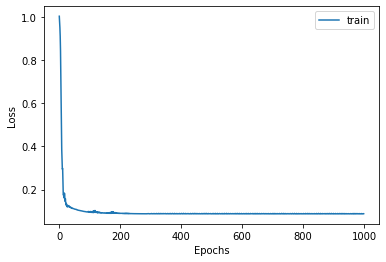

In [0]:
optimizer = torch.optim.Adam(order_model.parameters(), 1e-2, weight_decay=0.01)
lossfunc  = nn.MSELoss()

losses    = fit(order_model, Xtorch , Ytorch, lossfunc, optimizer, epochs=1000)
print("Final loss: %.4f" % losses[-1])

In [0]:
y_test_predict = order_model(Xtorch_test)
lossfunc(y_test_predict, Ytorch_test)

tensor(0.1076, device='cuda:0', grad_fn=<MseLossBackward>)

In [0]:
y_val_predict = order_model(Xtorch_val)
lossfunc(y_val_predict, Ytorch_val)

tensor(0.1143, device='cuda:0', grad_fn=<MseLossBackward>)

In [0]:
Xtorch_total = torch.FloatTensor(X.values).cuda()
Ytorch_total = torch.FloatTensor(y).cuda()

In [0]:
Y_total_predict = order_model(Xtorch_total)
lossfunc(Y_total_predict, Ytorch_total)

tensor(0.0967, device='cuda:0', grad_fn=<MseLossBackward>)

# Stacking and Cross Validation for meta_regressor

In [0]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from skorch import NeuralNet
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [0]:
net = NeuralNet(
    module=NN,
    criterion=nn.MSELoss,
    module__input_size=Xtorch.shape[1],
    module__hidden_size=50,
    module__output_size=Ytorch.shape[1],
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=0.005,
    max_epochs=100,
    
)

In [0]:
dt = DecisionTreeRegressor(max_depth=10)
svr = SVR(degree = 1,C = 0.8860298953772168,epsilon = 0.05377575926266184)

In [0]:
def choose_meta_regressor(X_train, y_train, X_val, y_val, regressors, meta_regressors):
    val_score_list = []
    score = float('inf')
    best_model = None
    for meta_regressor in meta_regressors:
        print(meta_regressor)
        stack_model = StackingRegressor(regressors=regressors, meta_regressor=meta_regressor)
        stack_model.fit(X_train, y_train)
        predict_train = stack_model.predict(X_train)
        predict_val = stack_model.predict(X_val)
        cur_score_train = mean_squared_error(y_pred=predict_train, y_true=y_train)
        cur_score_val = mean_squared_error(y_pred=predict_val, y_true=y_val)
        score_list = []
        score_list.append((cur_score_train, cur_score_val))
        print("train_score:", cur_score_train)
        print("val_score:", cur_score_val)
        if cur_score_val < score:
            best_model = stack_model
            score = cur_score_val
    return best_model, score_list

In [0]:
best_model, score_list = choose_meta_regressor(X_train.values.astype(np.float32), 
                                               y_train.astype(np.float32), 
                                               X_val.values.astype(np.float32),
                                               y_val.astype(np.float32),
                                               [svr, net, dt], 
                                               [SVR(kernel='rbf'), DecisionTreeRegressor(max_depth=10), Ridge(alpha=0.01), RandomForestRegressor(max_depth=10)])

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.3332        0.1593  0.2278
      2        0.1335        0.1390  0.2096
      3        0.1234        0.1379  0.2154
      4        0.1237        0.1416  0.2195
      5        0.1219        0.1398  0.2181
      6        0.1197        0.1332  0.2424
      7        0.1152        0.1340  0.2272
      8        0.1144        0.1349  0.2261
      9        0.1122        0.1333  0.2162
     10        0.1126        0.1354  0.2197
     11        0.1126        0.1329  0.2309
     12        0.1103        0.1342  0.2230
     13        0.1106        0.1311  0.2183
     14        0.1103        0.1331  0.2164
     15        0.1084        0.1314  0.2326
     16        0.1100        0.1288  0.2305
     17        0.1074        0.1321  0.2257
 

In [0]:
predicted_y_total = best_model.predict(X.values.astype(np.float32))

In [0]:
mean_squared_error(predicted_y_total, y)

0.095753730103763

In [0]:
data["predicted_count"] = scaler_y.inverse_transform(predicted_y_total)

In [0]:
data.tail()

order_in_section  speed  ...  hour_23  predicted_count
17550                28    6.0  ...        0        28.846481
17551                37    7.0  ...        0        38.590226
17552                13    7.0  ...        0        23.536613
17553                 5    7.0  ...        1        11.716898
17554                17    7.0  ...        1        11.716898

[5 rows x 129 columns]

In [0]:
data.to_csv("predicted_count.csv")